
=== Running: CountVectorizer Only ===

Training LogisticRegression (CountVectorizer Only)
Test Accuracy (LogisticRegression, CountVectorizer Only): 0.8595
Best Params: {'model__C': 0.1, 'model__solver': 'saga'}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.76      0.53      0.62      4386
        LIKE       0.88      0.95      0.91     15614

    accuracy                           0.86     20000
   macro avg       0.82      0.74      0.77     20000
weighted avg       0.85      0.86      0.85     20000



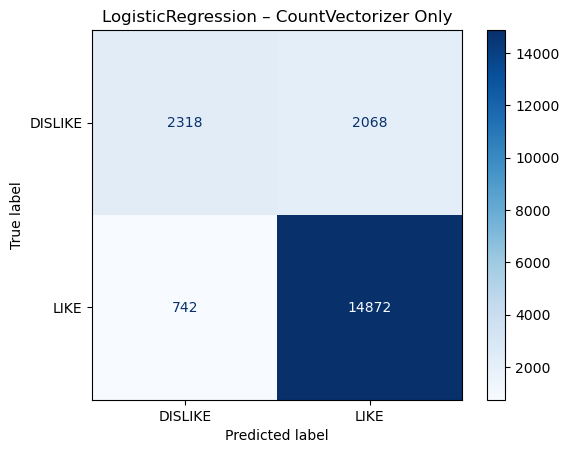


Training RandomForest (CountVectorizer Only)
Test Accuracy (RandomForest, CountVectorizer Only): 0.8720
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.84      0.51      0.64      4386
        LIKE       0.88      0.97      0.92     15614

    accuracy                           0.87     20000
   macro avg       0.86      0.74      0.78     20000
weighted avg       0.87      0.87      0.86     20000



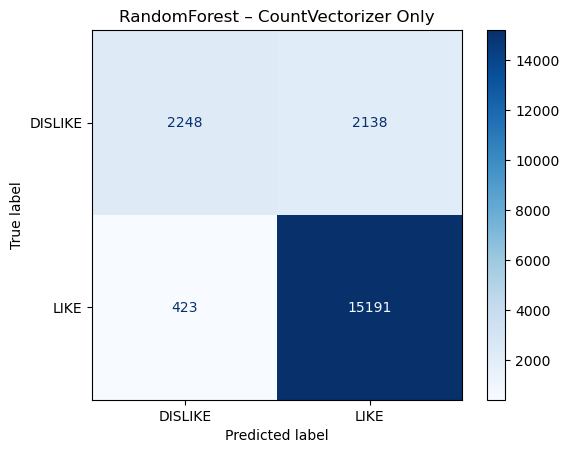


=== Running: CountVectorizer + Engineered ===

Training LogisticRegression (CountVectorizer + Engineered)
Test Accuracy (LogisticRegression, CountVectorizer + Engineered): 0.8598
Best Params: {'model__C': 10, 'model__solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.74      0.55      0.63      4386
        LIKE       0.88      0.95      0.91     15614

    accuracy                           0.86     20000
   macro avg       0.81      0.75      0.77     20000
weighted avg       0.85      0.86      0.85     20000



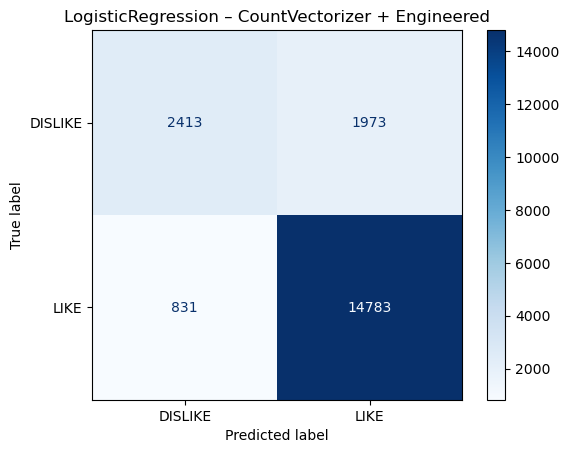


Training RandomForest (CountVectorizer + Engineered)
Test Accuracy (RandomForest, CountVectorizer + Engineered): 0.8694
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.86      0.48      0.62      4386
        LIKE       0.87      0.98      0.92     15614

    accuracy                           0.87     20000
   macro avg       0.87      0.73      0.77     20000
weighted avg       0.87      0.87      0.85     20000



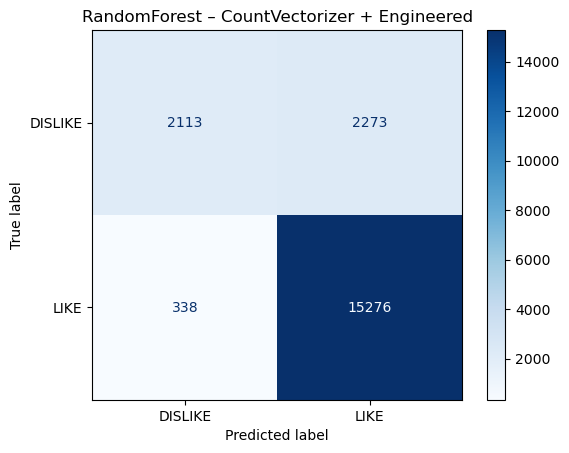

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Load pre-split datasets ---
train_df = pd.read_csv("train_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Binarize target ---
train_df['Label'] = train_df['Score'].apply(lambda x: 1 if x > 3 else 0)
test_df['Label'] = test_df['Score'].apply(lambda x: 1 if x > 3 else 0)

# --- Stratified sampling to match Landge setup ---
train_sample = train_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=80000/len(train_df), random_state=42))
test_sample = test_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=20000/len(test_df), random_state=42))

# --- Define features ---
engineered_features = [
    'TextLengthWords',
    'NumUppercaseWords',
    'AvgWordLength',
    'ContainsNegation',
    'TextToSummaryRatio',
    'NumExclamations'
]

# --- Extract data for modeling ---
X_text_train = train_sample['Text'].astype(str)
X_text_test = test_sample['Text'].astype(str)
X_eng_train = train_sample[engineered_features]
X_eng_test = test_sample[engineered_features]
y_train = train_sample['Label']
y_test = test_sample['Label']

# --- Preprocessing pipelines ---
text_transformer = Pipeline([
    ('vect', CountVectorizer(stop_words='english', max_features=1000))
])
engineered_transformer = Pipeline([
    ('scale', StandardScaler())
])

# --- Models and hyperparameters ---
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__solver': ['lbfgs', 'saga'],
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 10, None]
        }
    }
}

# --- Run models with and without engineered features ---
for include_engineered in [False, True]:
    mode = "CountVectorizer Only" if not include_engineered else "CountVectorizer + Engineered"
    print(f"\n=== Running: {mode} ===")

    if include_engineered:
        preprocessor = ColumnTransformer([
            ('text', text_transformer, 'Text'),
            ('engineered', engineered_transformer, engineered_features)
        ])
        X_train = train_sample[['Text'] + engineered_features]
        X_test = test_sample[['Text'] + engineered_features]
    else:
        preprocessor = ColumnTransformer([
            ('text', text_transformer, 'Text')
        ])
        X_train = train_sample[['Text']]
        X_test = test_sample[['Text']]

    for name, cfg in models.items():
        print(f"\nTraining {name} ({mode})")
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', cfg['model'])
        ])
        grid = GridSearchCV(pipe, cfg['params'], scoring='accuracy', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"Test Accuracy ({name}, {mode}): {acc:.4f}")
        print("Best Params:", grid.best_params_)
        print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['DISLIKE', 'LIKE']))

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DISLIKE', 'LIKE'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{name} – {mode}")
        plt.show()

